In [1]:
from LIFTraining import *

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

### for other test

In [3]:
p = create_default_params_LIF()

In [4]:
p['net_size'] = 1000
p['total_time'] = 20000
p['runtime'] = 20000
p['training_loops'] = 50

In [5]:
net = LIFTraining(p)

In [6]:
stim0 = np.zeros((p['net_size'], int(p['runtime']/p['dt'])))
stimc = np.zeros((p['net_size'], int(p['runtime']/p['dt']))) + 0.1
stimr = net.gen_rand_stim(0, 50) 

In [7]:
def gen_sine_targets(N, T, dt): 
    
    timesteps = int(T/dt)
    targets = np.zeros((N, timesteps))
    for i in range(N):
        amp = sp.stats.uniform.rvs() + 0.5
        t0 = sp.stats.uniform.rvs() * 2000
        t1 = sp.stats.uniform.rvs() * 1500 + 500
        x = np.linspace(0, T, num = timesteps)
        targets[i] = amp * np.sin(2 * np.pi * (x - t0)/t1)

    fout = np.zeros((1, timesteps))
    amp = sp.stats.uniform.rvs() + 0.5
    t0 = sp.stats.uniform.rvs() * 2000
    t1 = sp.stats.uniform.rvs() * 1500 + 500
    x = np.linspace(0, T, num = timesteps)
    fout[0] = amp * np.sin(2 * np.pi * (x - t0)/t1)
    return targets, fout

In [8]:
targ, fout = gen_sine_targets(net.N, net.T, net.dt)

In [9]:
# for i in range(5):
#     net.run_LIF(stimr)
net.trainGPU(stimc, targ, fout)

In [10]:
voltage, slow, fast = net.runGPU(stimc)

Text(0.5, 1.0, 'Behavior after training')

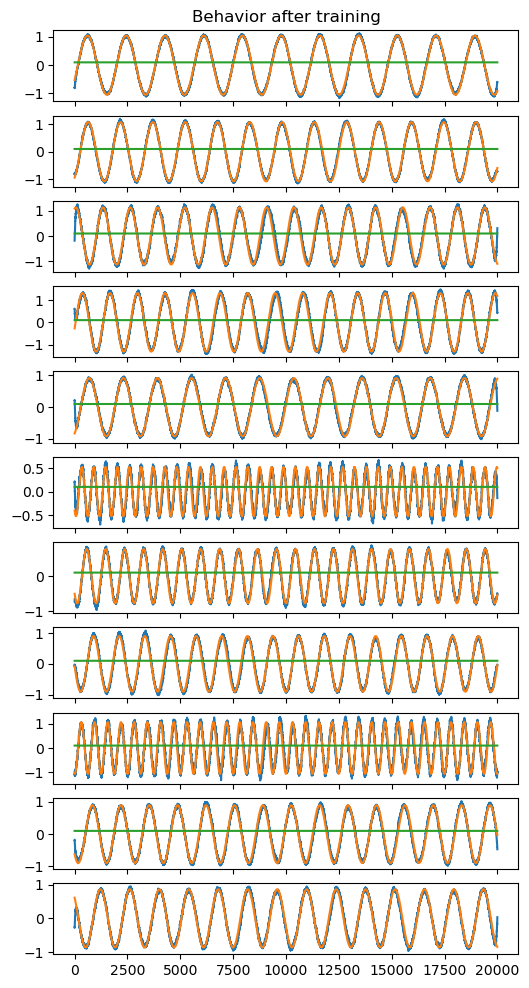

In [11]:
Jslow = np.dot(net.Js, slow)
Jout = np.dot(net.W_out, slow)
n_plot = 10
T = net.T
dt = net.dt

fig, axs = plt.subplots(n_plot  + 1, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jslow[i])
    axs[i].plot(targ[i])
    axs[i].plot(stimc[i])

axs[n_plot].plot(Jout[0])
axs[n_plot].plot(fout[0])

axs[0].set_title("Behavior after training")

In [24]:
voltage0, slow0, fast0 = net.runGPU(stim0 + 5)

Text(0.5, 1.0, 'Behavior after training')

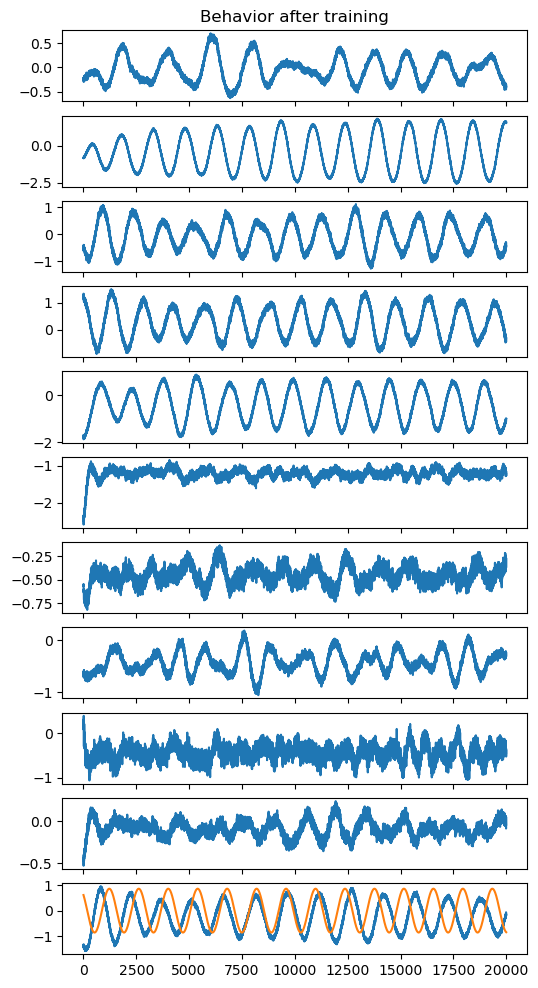

In [25]:
Jslow0 = np.dot(net.Js, slow0)
Jout0 = np.dot(net.W_out, slow0)
n_plot = 10
T = net.T
dt = net.dt

fig, axs = plt.subplots(n_plot  + 1, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jslow0[i])
    #axs[i].plot(stim0[i])

axs[n_plot].plot(Jout0[0])
axs[n_plot].plot(fout[0])

axs[0].set_title("Behavior after training")

Text(0.5, 1.0, 'Behavior after training')

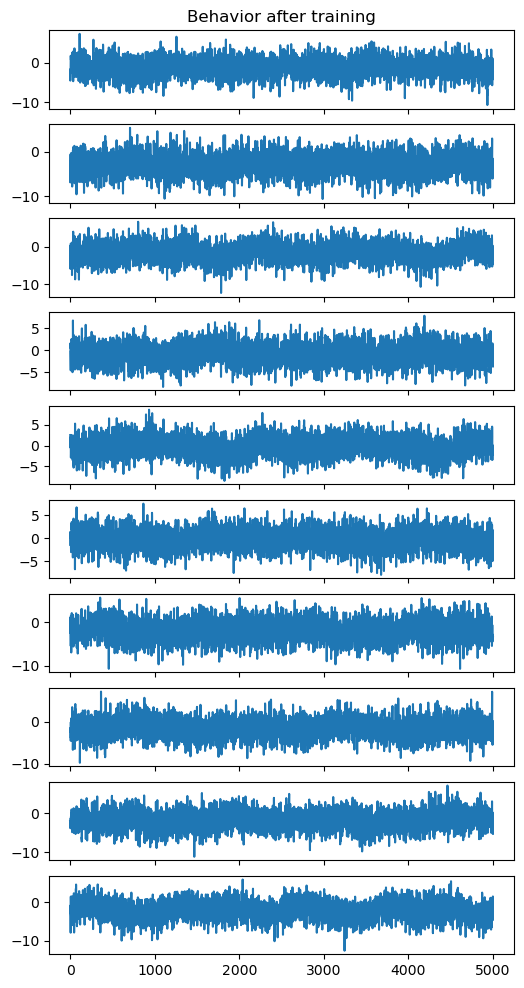

In [ ]:
Jfast = np.dot(net.Jf, fast)

n_plot = 10
T = net.T
dt = net.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jfast[i])
axs[0].set_title("Behavior after training")

Text(0.5, 1.0, 'Behavior after training')

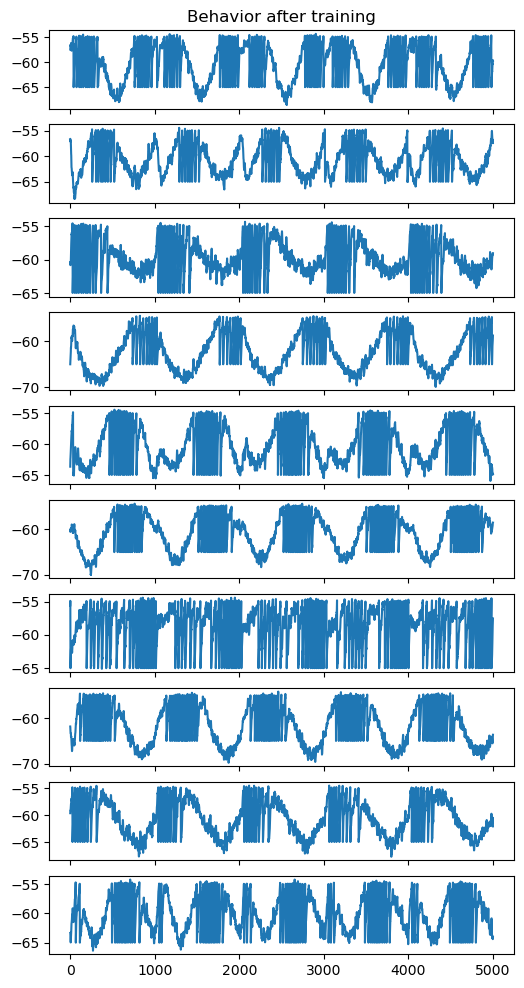

In [ ]:
n_plot = 10
T = net.T
dt = net.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(voltage[i])
axs[0].set_title("Behavior after training")

### step function periodic inputs

In [3]:
from LIFTraining import *
from RateTraining import *

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

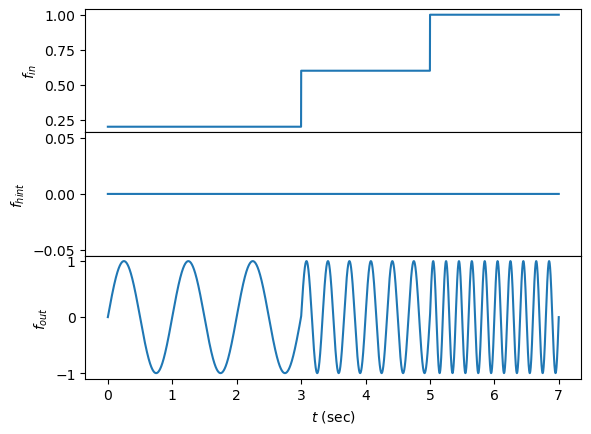

In [4]:
def inps_and_targs_periodic(dt, plot=False):
    n = 3
    pmin = 3
    
    min = 1
    mx = 5
    freqs = np.linspace(min, mx, n) 

    fin = np.zeros(0)
    fout = np.zeros(0)
    fhint = np.zeros(0)

    for f in freqs:
        p = max(2 * np.ceil(f), pmin)
        phase = np.linspace(0, p * 2 * np.pi, num=int(p / (f * dt))) 
        fin = np.hstack((fin, np.zeros(int(p / (f * dt))) + f/mx))
        fout = np.hstack((fout, np.sin(phase)))
        fhint = np.hstack((fhint, np.zeros(int(p / (f * dt)))))
    #fin[0:10] = 1

    t = np.linspace(0, np.shape(fin)[0]/1000, num = np.shape(fin)[0])

    # fin = np.reshape(fin, (1, fin.size)).T
    # fout = np.reshape(fout, (1, fout.size)).T
    # fhint = np.reshape(fhint, (1, fhint.size)).T

    if plot:
        fig, axs = plt.subplots(3, 1, sharex=True)
        plt.subplots_adjust(hspace=0)
        labels = ['$f_{in}$', '$f_{hint}$', '$f_{out}$']
        for ax, y, label in zip(axs, [fin, fhint, fout], labels):
            ax.plot(t, y)
            ax.set_ylabel(label)
        axs[-1].set_xlabel('$t$ (sec)')

    return (fin, fout, fhint)

dt = 0.001
fin, fout, _ = inps_and_targs_periodic(dt, plot=True)

In [5]:
rufin = np.outer(sp.stats.uniform.rvs(size = 300), fin)
rufout = np.outer(sp.stats.uniform.rvs(size = 300), fout)

ufin = np.outer(sp.stats.uniform.rvs(size = 300), fin)
ufout = np.outer(sp.stats.uniform.rvs(size = 300), fout)

In [6]:
rfp = create_default_params_rate()
rfp['total_time'] = np.shape(fin)[0]
rfp['runtime'] = np.shape(fin)[0]

In [7]:
rfp

{'net_size': 300,
 'num_out': 1,
 'tau_x': 10,
 'gain': 1,
 'total_time': 7000,
 'dt': 1,
 'lam': 1,
 'training_loops': 20,
 'train_every': 2,
 'm': 0,
 'std': 1,
 'cp': 1,
 'runtime': 7000}

In [8]:
rfnet = RateTraining(rfp)

In [9]:
for i in range(3):
    rfnet.runGPU(rufin + rufout)

_, Hxd = rfnet.runGPU(rufin + rufout)

In [10]:
aux_targs = Hxd + ufout

In [18]:
fp = create_default_params_LIF()
fp['training_loops'] = 100
fp['total_time'] = np.shape(fin)[0]
fp['runtime'] = np.shape(fin)[0]
fp['tau_s'] = 20

In [19]:
fnet = LIFTraining(fp)

In [20]:
for i in range(3):
    fnet.runGPU(ufin)

fnet.trainGPU(ufin, aux_targs, np.array([fout]))

In [21]:
testin = np.zeros(fnet.run_time) + 1
utestin = np.outer(sp.stats.uniform.rvs(size = fnet.N), testin)

In [22]:
voltage, slow, fast = fnet.runGPU(ufin)

Text(0.5, 1.0, 'Behavior after training')

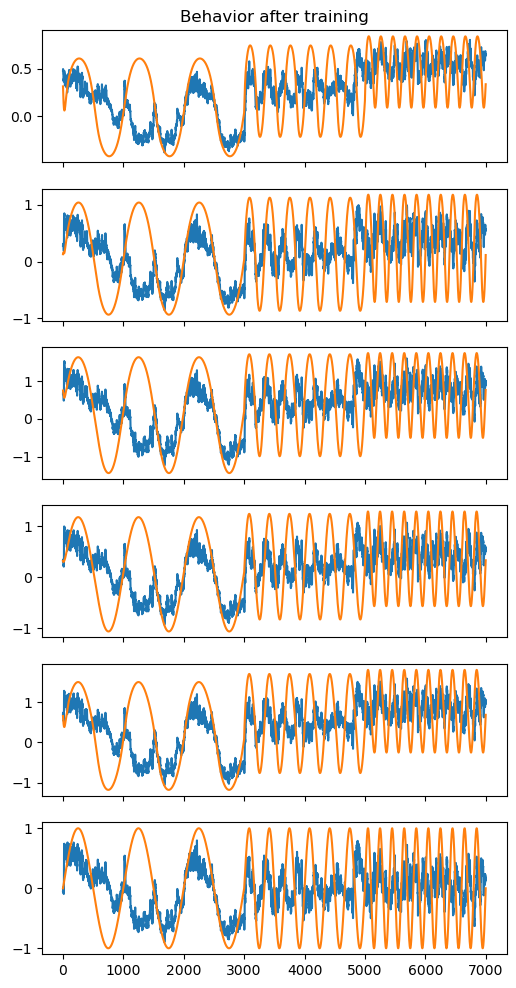

In [23]:
Jslow = np.dot(fnet.Js, slow)
wout = np.dot(fnet.W_out, slow)
n_plot = 5
T = fnet.T
dt = fnet.dt

fig, axs = plt.subplots(n_plot + fnet.num_outs, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jslow[i])
    axs[i].plot(aux_targs[i])
for i in range(fnet.num_outs):
    axs[n_plot + i].plot(wout[i])
    axs[n_plot + i].plot(fout)

axs[0].set_title("Behavior after training")

Text(0.5, 1.0, 'Behavior after training')

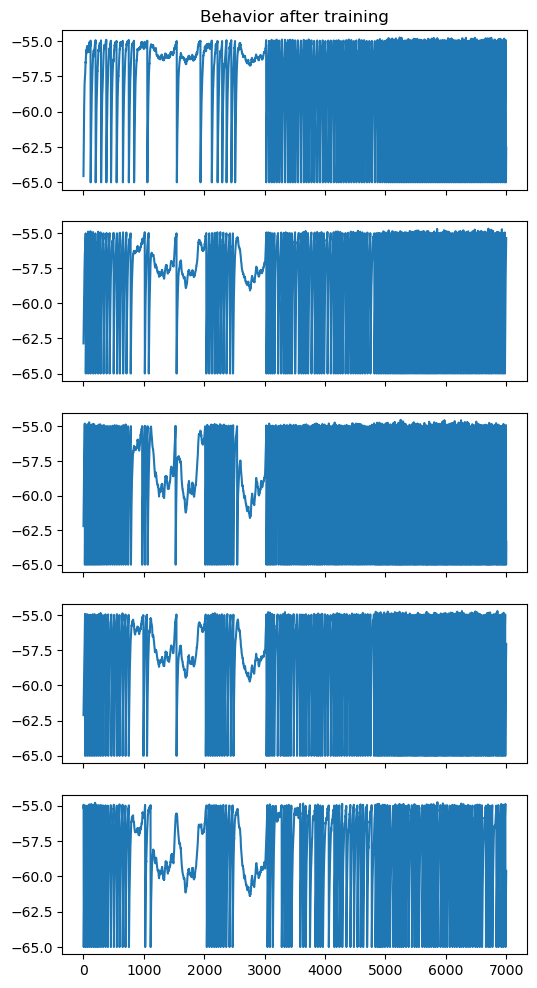

In [24]:
n_plot = 5
T = fnet.T
dt = fnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(voltage[i])
axs[0].set_title("Behavior after training")